In [4]:
import torch
from datasets import IndexedDataset, WeightedDataset
from torch.utils.data import DataLoader, DistributedSampler

from utils import get_args
from architectures import load_architecture

from samplers import DistributedCustomSampler
from losses import trades_loss, apgd_loss
from tqdm.notebook import tqdm
from architectures import load_architecture, add_lora, set_lora_gradients #load_statedict

import torch.nn as nn

args = get_args()
args.arch = 'resnet50'
args.dataset = 'CIFAR10'
args.selection_method = 'random'
args.aug = 'aug'
args.pre_trained = 'robust'
args.loss_function = 'APGD'

args.iterations = 20
args.pruning_ratio = 0.99
args.delta = 1
args.batch_size = 24
args.pruning_strategy = 'fixed_random'
args.batch_strategy = 'random'
args.sample_size= 128
args.init_lr = 0.001

# Example Usage

model = load_architecture(args)

# state_dict = torch.load('./state_dicts/convnext_tiny_22k_224.pth')
# model.load_state_dict(state_dict)
# model, target_layers = load_architecture(args)
# add_lora(args, model, target_layers)
# set_lora_gradients(args, model, target_layers)

# model.to('cuda')

train_dataset = WeightedDataset(args, train=True, prune_ratio = args.pruning_ratio,  )

train_sampler = DistributedCustomSampler(args, train_dataset, num_replicas=2, rank=0, drop_last=True)

trainloader = DataLoader(train_dataset, batch_size=None, sampler = train_sampler, ) #

./data
Files already downloaded and verified
500 50000


In [10]:
import math

# Example usage
original_data_size = 50000  # Size of original dataset
batch_size = 64             # Batch size for training
original_epochs = 50        # Number of epochs for original dataset

# Case 1: Pruning with 30% of data kept (70% pruned)
pruned_data_size_30 = int(0.30 * original_data_size)
adjusted_epochs_30 = adjust_epochs(original_data_size, pruned_data_size_30, batch_size, original_epochs)
print(f'Adjusted epochs for 30% pruned data: {adjusted_epochs_30}')

# Case 2: Pruning with 50% of data kept (50% pruned)
pruned_data_size_50 = int(0.50 * original_data_size)
adjusted_epochs_50 = adjust_epochs(original_data_size, pruned_data_size_50, batch_size, original_epochs)
print(f'Adjusted epochs for 50% pruned data: {adjusted_epochs_50}')

# Case 3: Pruning with 70% of data kept (30% pruned)
pruned_data_size_70 = int(0.70 * original_data_size)
adjusted_epochs_70 = adjust_epochs(original_data_size, pruned_data_size_70, batch_size, original_epochs)
print(f'Adjusted epochs for 70% pruned data: {adjusted_epochs_70}')

# Case 4: No pruning 
adjusted_epochs = adjust_epochs(original_data_size, original_data_size, batch_size, original_epochs)
print(f'Adjusted epochs for no pruning: {adjusted_epochs}')


Adjusted epochs for 30% pruned data: 167
Adjusted epochs for 50% pruned data: 100
Adjusted epochs for 70% pruned data: 72
Adjusted epochs for no pruning: 50


In [16]:
import timm

from timm.models import create_model

model = timm.create_model('convnext_tiny.fb_in22k', pretrained=True)

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

ResNet_imagenet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck_imagenet(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(

In [5]:
from losses import get_loss, get_eval_loss
import numpy as np
from losses import apgd_loss

rank = 'cuda'

optimizer = torch.optim.SGD( model.parameters(),lr=args.init_lr, weight_decay=args.weight_decay, momentum=args.momentum, nesterov=True, )

for iteration in range(args.iterations):

    model.eval()
    train_sampler.set_epoch(0)
    
    for batch_id, batch in tqdm(enumerate( trainloader ) ):
        # print(batch_id)
        if batch_id == 0:

            optimizer.zero_grad()

            data, target, idxs = batch

            # print(data,target, idxs)

            data, target = data.to(rank), target.to(rank) 

            loss_values, clean_values, robust_values, logits_nat, logits_adv = get_loss(args, model, data, target, optimizer)
#             # # print(logits_adv.shape)
#             # # print(logits_nat.shape)
#             # # assert torch.isfinite(loss_values).all(), "Loss contains NaNs!"
#             # # assert torch.isfinite(logits_nat).all(), "Logits_nat contains NaNs!"
#             # # assert torch.isfinite(logits_adv).all(), "Logits_adv contains NaNs!"

#             # # train_dataset.update_scores(iteration, idxs,loss_values)
#             # # train_dataset.update_scores(rank, idxs, clean_values, robust_values, loss_values, logits_nat, logits_adv)
            
            loss = train_dataset.compute_loss(idxs, loss_values)
            print(loss)

            loss.backward()
            optimizer.step()

#         # if args.pruning_strategy in [ 'decay_based', 'decay_based_v2', 'decay_based_v3']:
#         #     print('start decay')
#         #     indices = train_sampler.process_indices
#         #     train_dataset.decay_model.reset_counters()
#         #     results = torch.tensor([ train_dataset.decay_model.fit_predict( train_dataset.global_scores2[idx] ) for idx in indices ])
#         #     results = results.to(dtype=torch.float32)
#         #     train_dataset.alphas[indices] = results[:,0]
#         #     train_dataset.betas[indices] = results[:,1]
#         #     train_dataset.cetas[indices] = results[:,2]
#         #     train_dataset.pred_decay[indices] = results[:,4]
        
#         # print('betas',max(train_dataset.betas), min(train_dataset.betas) )
#         # print('pred decay', max(train_dataset.pred_decay), min(train_dataset.pred_decay) )
#         # print(train_dataset.alphas)

#         # print(loss)

pruning
remove tail
process


0it [00:00, ?it/s]

tensor(2.7639, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(2.1240, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(2.1852, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(2.0842, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(2.1205, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(2.1115, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.9621, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.7654, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.9486, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.8305, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.8641, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.6416, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.6504, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.7183, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.6112, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.6587, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.5124, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.4898, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.3070, device='cuda:0', grad_fn=<MeanBackward0>)
pruning
remove tail
process


0it [00:00, ?it/s]

tensor(1.3304, device='cuda:0', grad_fn=<MeanBackward0>)


In [6]:
from architectures.resnet_imagenet import ResNet_imagenet, Bottleneck_imagenet
model = ResNet_imagenet(Bottleneck_imagenet, [3, 4, 6, 3], )
num_features = model.fc.in_features
print(num_features)
model.fc = nn.Linear(num_features, 10)

2048


torch.Size([5, 60000])


  0%|          | 0/100 [00:00<?, ?it/s]

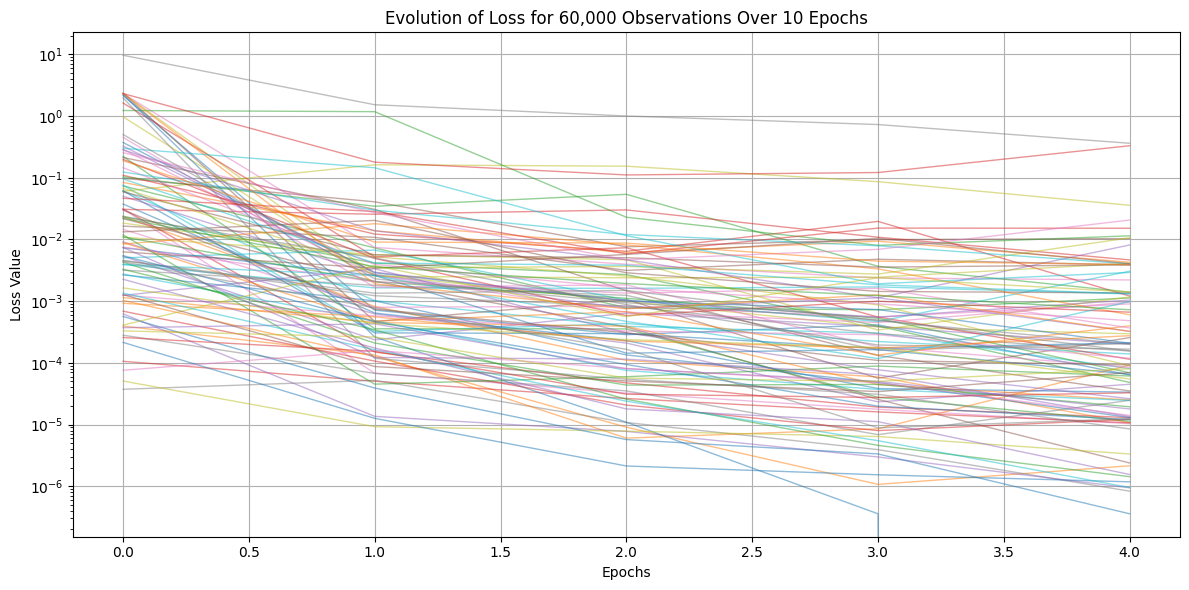

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a sample tensor with dimensions (10, 60000)
# Each of the 10 rows represents an epoch, and each column represents a loss value for one of the 60,000 observations.
np.random.seed(0)  # For reproducibility
tensor = train_dataset.global_scores2 #np.random.rand(10, 60000)  # Simulating loss values

# Sampling 1000 observations from the 60,000
print(tensor.shape)
sample_indices = np.random.choice(tensor.shape[1], size=100, replace=False)

sampled_tensor = tensor[:, sample_indices]

# Plotting the evolution of the loss for the 60,000 observations over 10 epochs
plt.figure(figsize=(12, 6))

# Plotting each observation's loss over the 10 epochs
for i in tqdm(range(sampled_tensor.shape[1])):
    plt.plot(range(args.iterations), sampled_tensor[:, i], alpha=0.5, linewidth=1)  # Plotting with low opacity and thin lines for clarity

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.yscale('log')  # Setting y-axis to log scale

plt.title('Evolution of Loss for 60,000 Observations Over 10 Epochs')
plt.grid(True)
plt.tight_layout()

plt.show()


In [3]:
observations_losses = train_dataset.global_scores2.T.numpy()

In [ ]:


import numpy as np

def obtain_latent_dataset(model, dataset, batch_size=32):

    # Assuming the dataset is a list or similar iterable with a known length
    num_samples = len(dataset)

    # Assume the dimensionality of the latent representation can be determined from one sample
    image,label, idx = dataset[0]
    image = torch.Tensor(image).to('cuda').unsqueeze(0)
    print(image.shape)
    first_latent_rep = model.get_latent_representation(image)
    latent_dim = first_latent_rep.shape[1]
    print(first_latent_rep.shape)
        
    # Preallocate the array for the latent representations
    latent_dataset = torch.zeros((num_samples, latent_dim))


    for i in tqdm( range(0, num_samples, batch_size) ):
        # Get the current batch of data
        batch_indices = list(range(i, min(i + batch_size, num_samples)))
        images,labels,idxs = dataset[batch_indices]
        images = images.to('cuda')
            
        # Process the batch to get latent representations
        batch_latent_reps = model.get_latent_representation(images) 
            
        # Store the results in the preallocated array
        latent_dataset[i:i + batch_size] = batch_latent_reps.detach().cpu()

    return latent_dataset

features =  obtain_latent_dataset(model,train_dataset,64)
train_dataset.define_latent_features(features)

